In [51]:
import torch
from torch.optim import Adam
import torch.nn.functional as F
from tqdm.auto import trange
import numpy as np
import matplotlib.pyplot as plt
from dgl.dataloading import GraphDataLoader
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning import Trainer
import pandas as pd
import dgl

from gnncloudmanufacturing.data import read_fatahi_dataset
from gnncloudmanufacturing.mip_solver import mip_solve
from gnncloudmanufacturing.validation import total_cost_from_graph, total_cost_from_gamma
from gnncloudmanufacturing.utils import GraphDataset, delta_from_gamma, graph_from_problem, gamma_from_target, os_type, ss_type, so_type
from gnncloudmanufacturing.graph_model import GNN

In [52]:
dataset = read_fatahi_dataset('../data/fatahi.xlsx')
len(dataset)

  0%|          | 0/18 [00:00<?, ?it/s]

18

In [53]:
train_problems = [dataset[0]]
val_problems = [dataset[2]]

In [54]:
for train_problem in train_problems:
    train_name = train_problem['name']
    train_delta = np.load(f'../data/optimal_solution/{train_name}/delta.npy')
    train_gamma = np.load(f'../data/optimal_solution/{train_name}/gamma.npy')
    total_cost = total_cost_from_gamma(train_problem, train_gamma, train_delta)
    print(f'Problem {train_problem["name"]}: {total_cost:.2f}')

Problem 5,10,10-1: 5086.08


In [55]:
for val_problem in val_problems:
    val_name = val_problem['name']
    val_delta = np.load(f'../data/optimal_solution/{val_name}/delta.npy')
    val_gamma = np.load(f'../data/optimal_solution/{val_name}/gamma.npy')
    total_cost = total_cost_from_gamma(val_problem, val_gamma, val_delta)
    print(f'Problem {val_problem["name"]}: {total_cost:.2f}')

Problem 5,10,10-3: 7652.32


In [56]:
train_graphs = []
for train_problem in train_problems:
    train_graph = graph_from_problem(train_problem, train_gamma)
    train_graph.edata['feat'][os_type][:, 0] /= 10
    train_graph.edata['feat'][ss_type][:] /= 100
    train_graphs.append(train_graph)

val_graphs = []
for val_problem in val_problems:
    val_graph = graph_from_problem(val_problem, val_gamma)
    val_graph.edata['feat'][os_type][:, 0] /= 10
    val_graph.edata['feat'][ss_type][:] /= 100
    val_graphs.append(val_graph)

In [57]:
train_dataset = GraphDataset(train_graphs)
val_dataset = GraphDataset(val_graphs)

In [58]:
train_dataloader = GraphDataLoader(train_dataset, batch_size=1)
val_dataloader = GraphDataLoader(val_dataset, batch_size=1)

In [64]:
model = GNN(
    ins_dim=1,
    ino_dim=2,
    out_dim=32,
    n_layers=2,
    lr=0.001,
    dropout_rate=0.2,
)
model

GNN(
  (convs): ModuleList(
    (0): AttnConvLayer(
      (W_s): Linear(in_features=1, out_features=32, bias=True)
      (W_os): Linear(in_features=4, out_features=32, bias=True)
      (W_ss): Linear(in_features=2, out_features=32, bias=True)
      (attn): Linear(in_features=64, out_features=1, bias=True)
      (W_in): Linear(in_features=2, out_features=32, bias=True)
      (W_self): Linear(in_features=2, out_features=32, bias=True)
      (W_out): Linear(in_features=2, out_features=32, bias=True)
      (W_o): Linear(in_features=96, out_features=32, bias=True)
    )
    (1): AttnConvLayer(
      (W_s): Linear(in_features=32, out_features=32, bias=True)
      (W_os): Linear(in_features=34, out_features=32, bias=True)
      (W_ss): Linear(in_features=33, out_features=32, bias=True)
      (attn): Linear(in_features=64, out_features=1, bias=True)
      (W_in): Linear(in_features=32, out_features=32, bias=True)
      (W_self): Linear(in_features=32, out_features=32, bias=True)
      (W_out):

In [65]:
trainer = Trainer(
    enable_progress_bar=False,
    max_epochs=1000,
    log_every_n_steps=1,
    logger=CSVLogger('.'),
    accelerator='cpu',
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/vitaliypozdnyakov/miniconda3/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


In [66]:
trainer.fit(
    model=model, 
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | convs   | ModuleList        | 13.4 K | train
1 | dropout | Dropout           | 0      | train
2 | dec     | DotProductDecoder | 0      | train
------------------------------------------------------
13.4 K    Trainable params
0         Non-trainable params
13.4 K    Total params
0.054     Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode
/Users/vitaliypozdnyakov/miniconda3/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/vitaliypozdnyakov/miniconda3/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not h

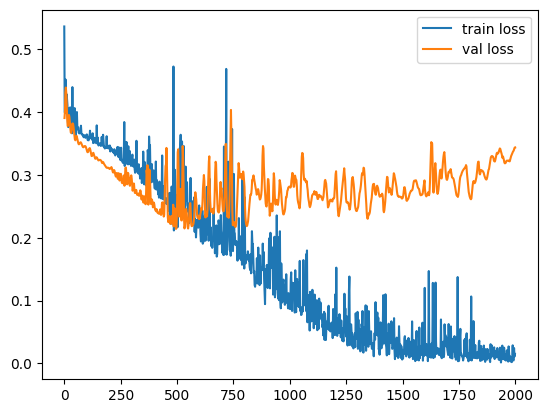

In [67]:
metrics = pd.read_csv(f'lightning_logs/version_{trainer.logger.version}/metrics.csv')
plt.plot(metrics.train_loss.dropna(), label='train loss')
plt.plot(metrics.val_loss.dropna(), label='val loss')
plt.legend()
plt.show()

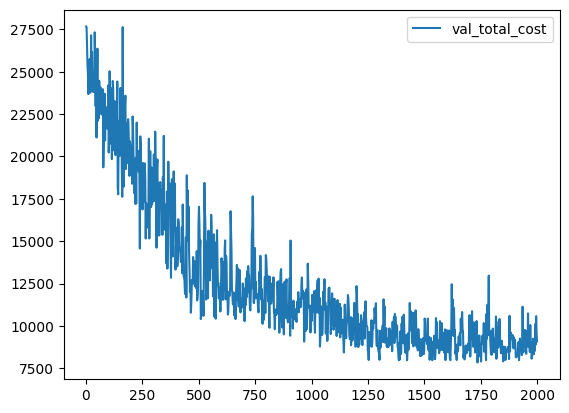

In [68]:
plt.plot(metrics.val_total_cost.dropna(), label='val_total_cost')
plt.legend()
plt.show()